In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import snscrape.modules.twitter as sntwitter
from tqdm.notebook import tqdm
from datetime import date, timedelta

In [2]:
%load_ext lab_black

## Start Exploration
#### Set Timeframes

In [3]:
today = date.today()
d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=365)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

#### Get Ticker info

In [4]:
stock = "AMZN"  # Could be also a list

In [5]:
stock_tkr = yf.Ticker(stock)
stock_hist = stock_tkr.history(start=start_date, end=end_date)

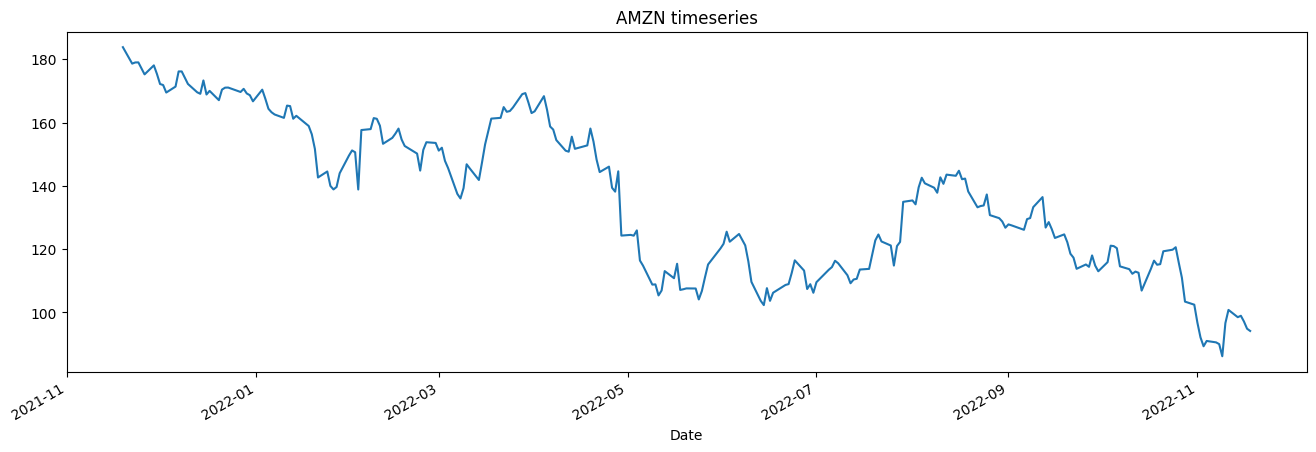

In [7]:
stock_hist["Close"].plot(figsize=(16, 5), title=f"{stock} timeseries")
plt.show()

## Reddit Scraper

In [8]:
import praw

In [9]:
from reddit_config import settings  # Load config files for secrets

In [10]:
reddit = praw.Reddit(
    client_id=settings.client_id,
    client_secret=settings.secret,
    user_agent=settings.app_name,
)

In [11]:
subreddits = ["WallStreetBets", "StockMarket", "Investing"]

#### Get top posts from the three top investing subreddits

In [12]:
# Searchs for the hotest posts inside the selected subreddits

latest_posts = []
for i, subreddit in tqdm(enumerate(subreddits), total=3):
    print(subreddit)

    hot_posts = reddit.subreddit(subreddit).hot(limit=20)

    for i, post in enumerate(hot_posts):
        latest_post_dict = {}
        latest_post_dict["title"] = post.title
        latest_post_dict["num_comments:"] = post.num_comments
        latest_post_dict["id"] = post.id
        latest_post_dict["score"] = post.score
        latest_post_dict["body"] = post.selftext
        latest_post_dict["createdat"] = post.created
        latest_post_dict["subreddit"] = post.subreddit.display_name
        latest_posts.append(latest_post_dict)
        # print(post.title)
    # posts[subreddit] = latest_posts

  0%|          | 0/3 [00:00<?, ?it/s]

WallStreetBets
StockMarket
Investing


In [13]:
reddit_posts = pd.DataFrame(latest_posts)

#### Get comments from one post

In [17]:
# submission = reddit.submission(id="yusfd3")
# for top_comment in submission.comments:
# print(top_comment.body)

### Search for AMZN posts

In [18]:
#Querys for a specific stock
stock_posts = []
for i, subreddit in tqdm(enumerate(subreddits), total=3):
    print(subreddit)
    hot_posts = reddit.subreddit(subreddit).search(query=stock, sort="hot", limit=100)
    for i, post in enumerate(hot_posts):
        stock_post_dict = {}
        stock_post_dict["title"] = post.title
        stock_post_dict["num_comments:"] = post.num_comments
        stock_post_dict["id"] = post.id
        stock_post_dict["score"] = post.score
        stock_post_dict["body"] = post.selftext
        stock_post_dict["createdat"] = post.created
        stock_post_dict["subreddit"] = post.subreddit.display_name
        stock_posts.append(stock_post_dict)

  0%|          | 0/3 [00:00<?, ?it/s]

WallStreetBets
StockMarket
Investing


In [47]:
stock_df = pd.DataFrame(stock_posts)
stock_df["createdat"] = pd.to_datetime(stock_df["createdat"], unit="s")
stock_df["date"] = stock_df["createdat"].dt.date
stock_df = stock_df.set_index("date")
stock_df

,title,num_comments:,id,score,body,createdat,subreddit
date,,,,,,,
2022-11-15,bears: “AMZN will nvr be a trillion dollar com...,61,ywdnhw,185,,2022-11-15 23:51:53,wallstreetbets
2022-11-16,Amzn LLY wmt Yolo moon,24,ywg525,14,,2022-11-16 01:44:59,wallstreetbets
2022-11-18,No Negative November ruined by meta puts,51,yyujci,111,,2022-11-18 21:02:32,wallstreetbets
2022-11-11,Not a bad Friday. Up $5k on a yolo from yester...,4,yskffr,22,,2022-11-11 19:29:59,wallstreetbets
2022-11-10,First $1 Trillion loss porn goes to $AMZN 📉🥳,28,yrl4gs,718,,2022-11-10 17:01:28,wallstreetbets
...,...,...,...,...,...,...,...
2021-01-08,Stock Tip! Know of Founder-led companies with ...,14,kst0ap,10,Congratulations to those that invested in SQ a...,2021-01-08 02:26:22,investing
2021-01-02,Does the purchase of options have any affect o...,93,kooxr7,358,"Let’s say for example that 100,000 people all ...",2021-01-02 02:34:51,investing
2021-01-01,Let's reflect on our performance in 2020,3,ko4235,0,"*Happy New Year, folks! It's certainly been an...",2021-01-01 03:20:43,investing


#### Lets try to get per post id the top 20 comments

In [20]:
stock_post_ids = stock_df["id"]
all_comments_dict = {}
for i, post_id in tqdm(enumerate(stock_post_ids), total=(stock_df).shape[0]):
    submission = reddit.submission(id=post_id)
    submission.comments.replace_more(
        limit=0
    )  # this is to avoide the MoreComments error
    _temp_lst = []
    for i, top_comment in enumerate(submission.comments):
        if top_comment.body.find("User Report") != -1:
            pass
        else:
            _temp_lst.append(top_comment.body)

        if i > 20:
            all_comments_dict[post_id] = _temp_lst
            break
        all_comments_dict[post_id] = _temp_lst

  0%|          | 0/300 [00:00<?, ?it/s]

In [21]:
all_comments_df = pd.DataFrame.from_dict(all_comments_dict, orient="index")

#### Sentiment Vader

In [23]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sent_analyzer = SentimentIntensityAnalyzer()

In [25]:
def calculate_mean(lst: list[float]) -> float:
    average = sum(lst) / len(lst)
    return average

In [26]:
sent_dict = {}
for comments in all_comments_df.itertuples():
    _poslst = []
    _neulst = []
    _neglst = []
    _complst = []
    for i, sentence in enumerate(comments):
        if i == 0:
            key = sentence
            continue

        pos = sent_analyzer.polarity_scores(str(sentence))["pos"]
        neg = sent_analyzer.polarity_scores(str(sentence))["neg"]
        neu = sent_analyzer.polarity_scores(str(sentence))["neu"]
        comp = sent_analyzer.polarity_scores(str(sentence))["compound"]
        _poslst.append(pos)
        _neulst.append(neu)
        _neglst.append(neg)
        _complst.append(comp)

        if i == len(comments) - 1:
            _temp = {}
            _temp["pos"] = calculate_mean(_poslst)
            _temp["neu"] = calculate_mean(_neulst)
            _temp["neg"] = calculate_mean(_neglst)
            _temp["comp"] = calculate_mean(_complst)

            sent_dict[key] = _temp

We now have a dictionary of the average sent of the comments lets merge

In [27]:
sent_df = pd.DataFrame.from_dict(sent_dict, orient="index")
sent_df

,pos,neu,neg,comp
ywdnhw,0.131182,0.804136,0.064773,0.180359
ywg525,0.039318,0.899455,0.061182,-0.085682
yyujci,0.060091,0.890500,0.049364,0.028318
yskffr,0.012818,0.983500,0.003682,0.051836
yrl4gs,0.118727,0.780045,0.101182,-0.001414
...,...,...,...,...
kst0ap,0.067682,0.925455,0.006864,0.098645
kooxr7,0.064955,0.894273,0.040818,0.136127
ko4235,0.005818,0.989091,0.005091,-0.009745
kjllvi,0.053364,0.918591,0.028091,0.012209


In [52]:
stock_sent_df = pd.merge(
    stock_df, sent_df, how="inner", left_on="id", right_on=sent_df.index
)

In [53]:
title_sent = {}
for title in stock_sent_df["title"]:
    pos = sent_analyzer.polarity_scores(str(title))["pos"]
    neg = sent_analyzer.polarity_scores(str(title))["neg"]
    neu = sent_analyzer.polarity_scores(str(title))["neu"]
    comp = sent_analyzer.polarity_scores(str(title))["compound"]
    if comp >= 0:
        title_sent[title] = pos

    else:
        title_sent[title] = -neg

In [54]:
title_sent_df = pd.DataFrame.from_dict(title_sent, orient="index")

In [55]:
stock_sent_df = pd.merge(
    stock_sent_df,
    title_sent_df,
    how="inner",
    left_on="title",
    right_on=title_sent_df.index,
)
stock_sent_df.rename(columns={0: "title_sent"}, inplace=True)

#### Lets clean up a bit the sentiment of the comments

In [56]:
stock_sent_df["cmt_sent"] = stock_sent_df[["pos", "neg", "comp"]].apply(
    lambda row: row["pos"] if row["comp"] >= 0 else -row["neg"], axis=1
)

In [57]:
stock_sent_df.head()

,title,num_comments:,id,score,body,createdat,subreddit,pos,neu,neg,comp,title_sent,cmt_sent
0,bears: “AMZN will nvr be a trillion dollar com...,61,ywdnhw,185,,2022-11-15 23:51:53,wallstreetbets,0.131182,0.804136,0.064773,0.180359,0.000,0.131182
1,Amzn LLY wmt Yolo moon,24,ywg525,14,,2022-11-16 01:44:59,wallstreetbets,0.039318,0.899455,0.061182,-0.085682,0.344,-0.061182
2,No Negative November ruined by meta puts,51,yyujci,111,,2022-11-18 21:02:32,wallstreetbets,0.060091,0.890500,0.049364,0.028318,-0.692,0.060091
3,Not a bad Friday. Up $5k on a yolo from yester...,4,yskffr,22,,2022-11-11 19:29:59,wallstreetbets,0.012818,0.983500,0.003682,0.051836,0.331,0.012818
4,First $1 Trillion loss porn goes to $AMZN 📉🥳,28,yrl4gs,718,,2022-11-10 17:01:28,wallstreetbets,0.118727,0.780045,0.101182,-0.001414,-0.223,-0.101182


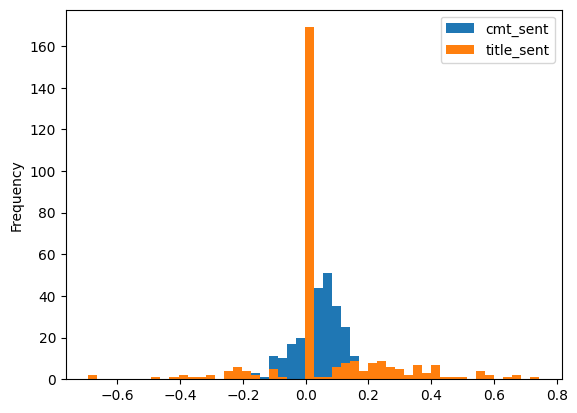

In [58]:
stock_sent_df[["cmt_sent", "title_sent"]].plot(kind="hist", bins=50)
plt.show()

We can see a lot of neutral values for the title

In [59]:
stock_sent_df["date"] = stock_sent_df["createdat"].dt.date

In [60]:
stock_sent_df.set_index("date", inplace=True)

C:\Users\joses\AppData\Local\Temp\ipykernel_41832\3633993025.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  stock_sent_df.groupby("date")["cmt_sent", "title_sent"].mean().plot(figsize=(16, 5))


<AxesSubplot: xlabel='date'>

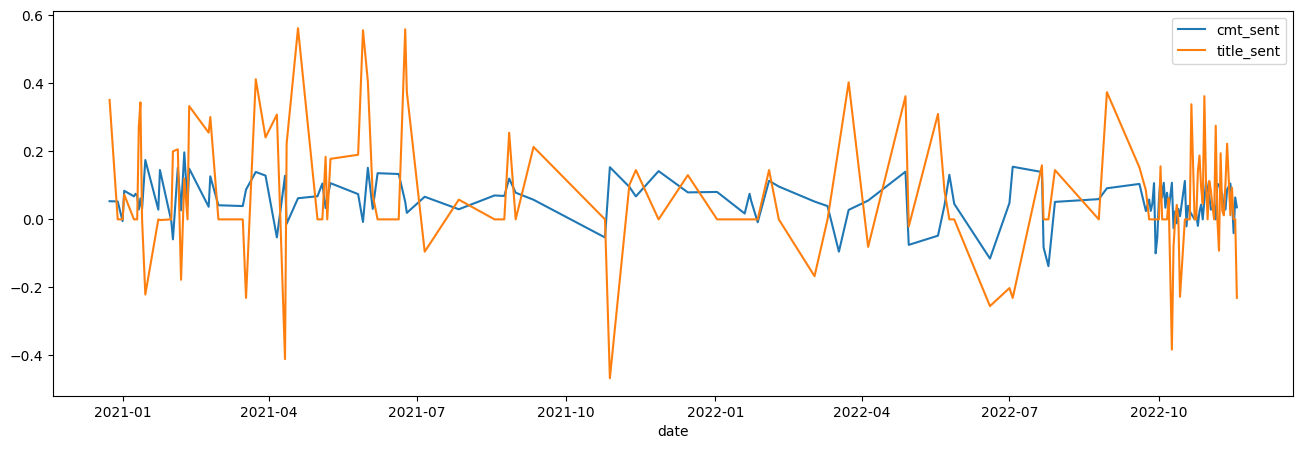

In [61]:
stock_sent_df.groupby("date")["cmt_sent", "title_sent"].mean().plot(figsize=(16, 5))

In [63]:
stock

'AMZN'

In [110]:
stock_hist["date"] = pd.to_datetime(stock_hist.index).date
stock_hist.set_index("date", inplace=True)
stock_hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
date,,,,,,,
2021-11-19,185.634506,188.107498,183.785995,183.828506,98734000,0,0.0
2021-11-22,183.819000,185.673004,178.375000,178.628494,96844000,0,0.0
2021-11-23,179.251999,181.052505,176.385498,179.001999,73804000,0,0.0
2021-11-24,178.133499,180.682007,176.842499,179.020493,46560000,0,0.0
2021-11-26,180.104996,181.675003,175.207504,175.227997,59826000,0,0.0
...,...,...,...,...,...,...,...
2022-11-14,98.769997,100.120003,97.290001,98.489998,99533100,0,0.0
2022-11-15,103.209999,103.790001,97.339996,98.940002,111336300,0,0.0
2022-11-16,96.849998,98.489998,95.540001,97.120003,87958800,0,0.0


In [111]:
merg_stock_sent_df = pd.merge(
    stock_sent_df, stock_hist, how="inner", left_index=True, right_index=True
)

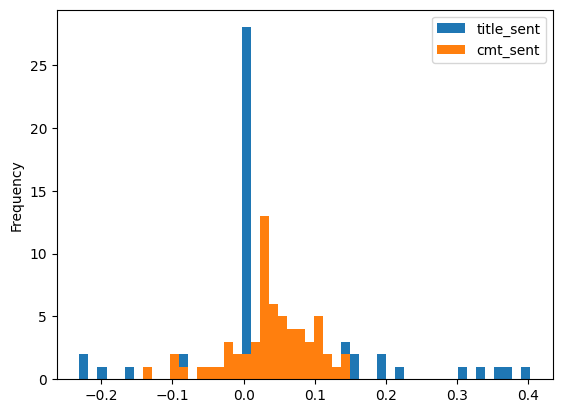

In [112]:
merg_stock_sent_df.groupby("date")[["title_sent", "cmt_sent"]].mean().plot(
    kind="hist", bins=50
)
plt.show()

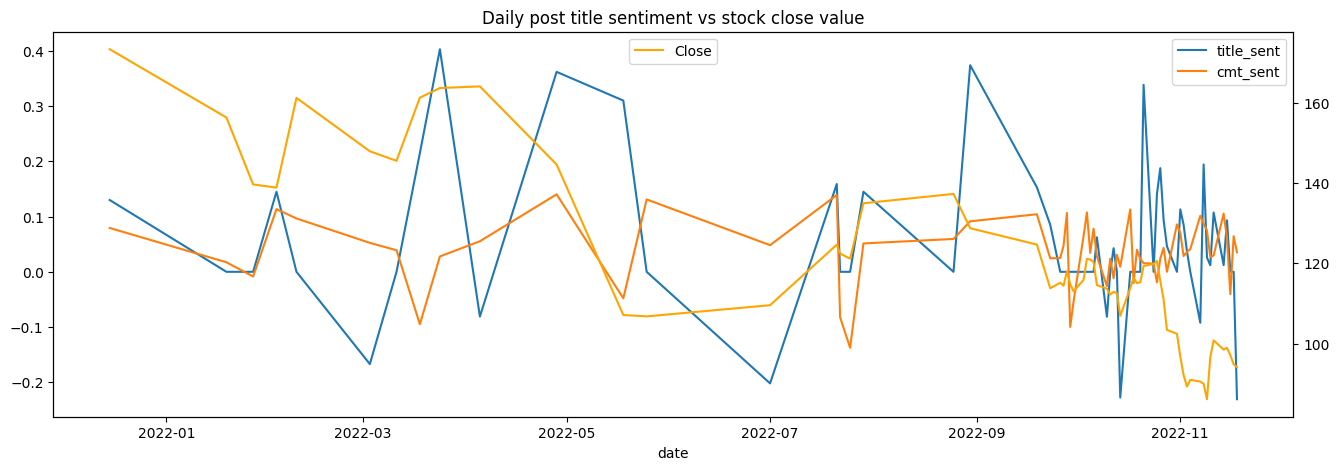

In [113]:
ax = (
    merg_stock_sent_df.groupby("date")[["title_sent", "cmt_sent"]]
    .mean()
    .plot(figsize=(16, 5))
)
ax2 = ax.twinx()
ax2 = merg_stock_sent_df["Close"].plot(ax=ax2, color="orange", legend="close price")
ax2.legend(loc="upper center")
plt.title("Daily post title sentiment vs stock close value")
plt.show()

In [73]:
merg_stock_sent_df.to_parquet("reddit_amzn.parquet")

#### Sentiment Transformers


In [77]:
from transformers import pipeline

model = f"cardiffnlp/twitter-roberta-base-sentiment-latest"  # model trained for twitter comments
alt_model = f"ProsusAI/finbert"  # This is a model trained with financial vocabulary
# sentiment_task = pipeline("sentiment-analysis", model=model)
sentiment_task = pipeline("sentiment-analysis", model=alt_model)
sentiment_task("The market is very bullish!")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'positive', 'score': 0.3981960117816925}]

In [78]:
sent_dict = {}
for comments in tqdm(all_comments_df.itertuples(), total=len(all_comments_df)):
    _lst = []

    for i, sentence in enumerate(comments):
        if i == 0:
            key = sentence
            continue

        sent = sentiment_task(str(sentence))
        _lst.append(sent)

        if i == len(comments) - 1:
            # _temp = {}
            # _temp["pos"] = calculate_mean(_poslst)

            sent_dict[key] = _lst

  0%|          | 0/290 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


In [79]:
sent_dict

{'ywdnhw': [[{'label': 'positive', 'score': 0.5104692578315735}],
  [{'label': 'negative', 'score': 0.37466001510620117}],
  [{'label': 'negative', 'score': 0.37165358662605286}],
  [{'label': 'negative', 'score': 0.3423420488834381}],
  [{'label': 'neutral', 'score': 0.3755435645580292}],
  [{'label': 'neutral', 'score': 0.3694118559360504}],
  [{'label': 'negative', 'score': 0.3647158145904541}],
  [{'label': 'negative', 'score': 0.3743472397327423}],
  [{'label': 'neutral', 'score': 0.350894570350647}],
  [{'label': 'negative', 'score': 0.3456774055957794}],
  [{'label': 'neutral', 'score': 0.39750853180885315}],
  [{'label': 'negative', 'score': 0.35262948274612427}],
  [{'label': 'positive', 'score': 0.517799437046051}],
  [{'label': 'negative', 'score': 0.43687814474105835}],
  [{'label': 'negative', 'score': 0.35923609137535095}],
  [{'label': 'neutral', 'score': 0.36336782574653625}],
  [{'label': 'neutral', 'score': 0.3575694262981415}],
  [{'label': 'neutral', 'score': 0.3653

In [96]:
nn_sent_df = pd.DataFrame.from_dict(sent_dict)
nn_sent_df

,ywdnhw,ywg525,yyujci,yskffr,yrl4gs,yxnwxv,yx7x8z,yro7sv,yvcvtv,yvynnh,...,kwbpmv,kvfjk5,kvnsg5,koyjya,ktrrza,kst0ap,kooxr7,ko4235,kjllvi,kmimiv
0,"[{'label': 'positive', 'score': 0.510469257831...","[{'label': 'neutral', 'score': 0.3563813269138...","[{'label': 'negative', 'score': 0.375878274440...","[{'label': 'negative', 'score': 0.408406734466...","[{'label': 'negative', 'score': 0.390838980674...","[{'label': 'negative', 'score': 0.430888503789...","[{'label': 'negative', 'score': 0.370850473642...","[{'label': 'positive', 'score': 0.381588459014...","[{'label': 'negative', 'score': 0.401856690645...","[{'label': 'negative', 'score': 0.374560922384...",...,"[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225...","[{'label': 'negative', 'score': 0.417494267225..."
1,"[{'label': 'negative', 'score': 0.374660015106...","[{'label': 'neutral', 'score': 0.3632957041263...","[{'label': 'neutral', 'score': 0.3886635601520...","[{'label': 'negative', 'score': 0.369634211063...","[{'label': 'neutral', 'score': 0.3677788972854...","[{'label': 'positive', 'score': 0.363390684127...","[{'label': 'neutral', 'score': 0.3643914461135...","[{'label': 'positive', 'score': 0.494940608739...","[{'label': 'negative', 'score': 0.366257756948...","[{'label': 'negative', 'score': 0.387436062097...",...,"[{'label': 'negative', 'score': 0.364900201559...","[{'label': 'neutral', 'score': 0.3549505770206...","[{'label': 'negative', 'score': 0.405270636081...","[{'label': 'negative', 'score': 0.389118134975...","[{'label': 'neutral', 'score': 0.3469513058662...","[{'label': 'negative', 'score': 0.404170006513...","[{'label': 'negative', 'score': 0.341978728771...","[{'label': 'negative', 'score': 0.421432167291...","[{'label': 'neutral', 'score': 0.3554512560367...","[{'label': 'negative', 'score': 0.386227339506..."
2,"[{'label': 'negative', 'score': 0.371653586626...","[{'label': 'positive', 'score': 0.372053474187...","[{'label': 'positive', 'score': 0.372178286314...","[{'label': 'negative', 'score': 0.362073481082...","[{'label': 'negative', 'score': 0.385780721902...","[{'label': 'negative', 'score': 0.372853666543...","[{'label': 'negative', 'score': 0.372679859399...","[{'label': 'negative', 'score': 0.389339625835...","[{'label': 'negative', 'score': 0.407768070697...","[{'label': 'negative', 'score': 0.373407632112...",...,"[{'label': 'negative', 'score': 0.405537188053...","[{'label': 'neutral', 'score': 0.3443400561809...","[{'label': 'negative', 'score': 0.396373987197...","[{'label': 'positive', 'score': 0.356625199317...","[{'label': 'positive', 'score': 0.369977235794...","[{'label': 'negative', 'score': 0.384193986654...","[{'label': 'neutral', 'score': 0.3548706471920...","[{'label': 'negative', 'score': 0.362073481082...","[{'label': 'negative', 'score': 0.345655590295...","[{'label': 'negative', 'score': 0.345073670148..."
3,"[{'label': 'negative', 'score': 0.342342048883...","[{'label': 'neutral', 'score': 0.3650296032428...","[{'label': 'negative', 'score': 0.363289833068...","[{'label': 'negative', 'score': 0.362073481082...","[{'label': 'neutral', 'score': 0.3574265241622...","[{'label': 'neutral', 'score': 0.3636472225189...","[{'label': 'positive', 'score': 0.371616452932...","[{'label': 'neutral', 'score': 0.4166097044944...","[{'label': 'neutral', 'score': 0.3698318302631...","[{'label': 'negative', 'score': 0.404071986675...",...,"[{'label': 'positive', 'score': 0.335950851440...","[{'label': 'negative', 'score': 0.390479475259...","[{'label': 'neutral', 'score': 0.3759638667106...","[{'label': 'negative', 'score': 0.

In [100]:
columns = nn_sent_df.columns
post_sent = {}
for column, data in nn_sent_df.items():
    lst = []
    for row in data:
        if row[0]["label"] == "positive":
            print("positive", row[0]["score"])
            lst.append(row[0]["score"])
        if row[0]["label"] == "neutral":
            print("neutral", row[0]["score"])
            lst.append(0)
        if row[0]["label"] == "negative":
            print("negative", -row[0]["score"])
            lst.append(-row[0]["score"])
    # print(lst)
    post_sent[column] = sum(lst) / len(lst)

positive 0.5104692578315735
negative -0.37466001510620117
negative -0.37165358662605286
negative -0.3423420488834381
neutral 0.3755435645580292
neutral 0.3694118559360504
negative -0.3647158145904541
negative -0.3743472397327423
neutral 0.350894570350647
negative -0.3456774055957794
neutral 0.39750853180885315
negative -0.35262948274612427
positive 0.517799437046051
negative -0.43687814474105835
negative -0.35923609137535095
neutral 0.36336782574653625
neutral 0.3575694262981415
neutral 0.3653915524482727
positive 0.42479830980300903
neutral 0.35131096839904785
negative -0.33996132016181946
negative -0.36207348108291626
neutral 0.3563813269138336
neutral 0.36329570412635803
positive 0.37205347418785095
neutral 0.36502960324287415
neutral 0.3776407837867737
neutral 0.3963063657283783
neutral 0.3748326003551483
negative -0.3712567687034607
negative -0.369634211063385
negative -0.3377210795879364
negative -0.36825937032699585
neutral 0.36844778060913086
positive 0.3401247560977936
neutral

In [114]:
nn_post_sent_df = pd.DataFrame.from_dict(post_sent, orient="index")
nn_post_sent_df

,0
ywdnhw,-0.116869
ywg525,-0.165058
yyujci,-0.166560
yskffr,-0.364523
yrl4gs,-0.130993
...,...
kst0ap,-0.302915
kooxr7,0.009174
ko4235,-0.367291
kjllvi,-0.205123


In [115]:
merg_stock_sent_df = merg_stock_sent_df.merge(
    nn_post_sent_df, how="inner", left_on="id", right_on=nn_post_sent_df.index
)

In [116]:
merg_stock_sent_df.rename(columns={0: "nn_comment_sent"}, inplace=True)

In [118]:
merg_stock_sent_df["date"] = merg_stock_sent_df["createdat"].dt.date
merg_stock_sent_df.set_index("date", inplace=True)
merg_stock_sent_df

,title,num_comments:,id,score,body,createdat,subreddit,pos,neu,neg,...,title_sent,cmt_sent,Open,High,Low,Close,Volume,Dividends,Stock Splits,nn_comment_sent
date,,,,,,,,,,,,,,,,,,,,,
2021-12-15,Top 5 Metaverse stocks to invest in for the mi...,102,rguzzu,5,Hello Everyone. I am curious to read your opi...,2021-12-15 09:09:37,investing,0.079364,0.867545,0.053091,...,0.130,0.079364,168.598007,173.600006,165.195007,173.315002,75794000,0,0.0,-0.211583
2022-01-19,"Sentiment Analysis for Tuesday, January 18",22,s82n9w,11,Hey everyone. I made code to automate some sen...,2022-01-19 22:34:53,investing,0.017227,0.971818,0.011000,...,0.000,0.017227,158.761993,159.250000,156.250000,156.298996,53242000,0,0.0,-0.250667
2022-01-27,Why does this website show the S&P P/E ratio a...,25,sdqliy,0,|Ticker|Market cap|Weight|Notes|EPS|Last|Manua...,2022-01-27 05:13:17,investing,0.015273,0.976318,0.008455,...,0.000,-0.008455,140.800003,144.243500,139.350006,139.637497,77516000,0,0.0,-0.284496
2022-02-03,"Amazon stock soars 15% after earnings, will hi...",524,sjvmmh,1764,Article link: https://finance.yahoo.com/news/a...,2022-02-03 21:59:15,investing,0.113545,0.776545,0.109909,...,0.145,0.113545,141.737503,144.247498,138.332993,138.845505,225532000,0,0.0,-0.089096
2022-02-09,"Long Term Investing - Blue Chips ($aapl, $msft...",103,solq1q,21,I see a lot of posts saying to just throw your...,2022-02-09 19:29:28,investing,0.096591,0.844682,0.058727,...,0.000,0.096591,162.873505,163.834503,160.250000,161.189499,68786000,0,0.0,-0.140370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-16,"Market Close - November 16, 2022",1,yx66ql,1,,2022-11-16 21:04:45,StockMarket,0.000000,0.988273,0.011727,...,0.000,-0.011727,96.849998,98.489998,95.540001,97.120003,87958800,0,0.0,-0.325452
2022-11-17,Recent development in hydrogen,20,yxnwxv,39,"Plug Power (NASDAQ: PLUG), a leading provider...",2022-11-17 11:32:10,wallstreetbets,0.064500,0.904227,0.031227,...,0.000,0.064500,95.370003,96.970001,94.029999,94.849998,82617900,0,0.0,-0.252202
2022-11-18,No Negative November ruined by meta puts,51,yyujci,111,,2022-11-18 21:02:32,wallstreetbets,0.060091,0.890500,0.049364,...,-0.692,0.060091,95.949997,95.989998,92.480003,94.139999,72336500,0,0.0,-0.166560


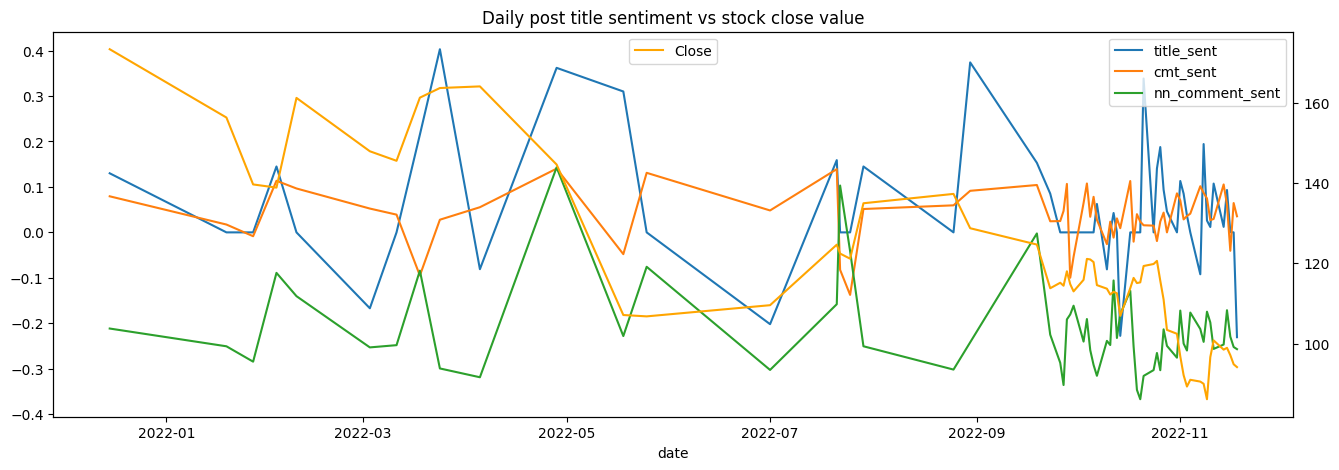

In [120]:
ax = (
    merg_stock_sent_df.groupby("date")[["title_sent", "cmt_sent", "nn_comment_sent"]]
    .mean()
    .plot(figsize=(16, 5))
)
ax.legend(loc="upper right")
ax2 = ax.twinx()
ax2 = merg_stock_sent_df["Close"].plot(ax=ax2, color="orange", legend="close price")
ax2.legend(loc="upper center")
plt.title("Daily post title sentiment vs stock close value")
plt.show()